# 프로젝트 뉴스기사 요약해보기

Step 1. 데이터 수집하기<br/>
Step 2. 데이터 전처리하기<br/>
Step 3. 어텐션 매커니즘 사용하기<br/>
Step 4. 실제 결과와 요약문 비교하기<br/>
Step 5. Summa를 이용해서 추출적 요약해보기<br/>


## Step 0. 라이브러리 불러오기

In [1]:
import re
import pandas as pd
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Step 1. 데이터 수집하기

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
15476,"Newly wed woman gangraped by husband, relative...",A newly married woman in Haryana's Kurukshetra...
85526,Starbucks customer calls black man slave over ...,"A man, who was caught on video yelling racial ..."
5780,Car crashes into Parliament entrance barricade...,A car crashed into a barricade at the entrance...
84823,Man puts fake power outlet stickers for chargi...,A prankster placed stickers resembling power o...
35160,Parliamentary panel summons RBI Governor over ...,A parliamentary panel has reportedly summoned ...
88067,Novak Djokovic appoints Andre Agassi as new coach,World number two Serbia's Novak Djokovic has a...
91227,Hostel in Pakistan prohibits girls from sharin...,The International Islamic University in Islama...
90080,RSS wing prescribes ways to have perfect 'cust...,RSS's health wing Arogya Bharati under its Gar...
91106,New India based on EPI (Every Person Important...,In the 31st edition of his monthly radio broad...
72149,3 Delhi men arrested for duping 200 ATM users,The Delhi Police on Thursday arrested three me...


## Step 2. 데이터 전처리하기

**결측치 확인하기**

In [4]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

두개의 컬럼 모두 결측치가 없으므로 결측치 제거 안함

**중복값 제거**

`headline`은 요약된 문장이므로 중복될 수 있다. 하지만 Text가 중복되는 경우는 제거해야한다.

In [5]:
prev_data_len = len(data)
data.drop_duplicates(subset=['text'], inplace=True)
print(f"중복 제거 후 전체 데이터수 : {prev_data_len} -> {len(data)}")

중복 제거 후 전체 데이터수 : 98401 -> 98360


**정규화 및 불용어 제거**

In [6]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [7]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

**전처리 동작확인**

In [8]:
temp_text = data.loc[0]['text']
temp_headline = data.loc[0]['headlines']

print(temp_text, "\n-> ", preprocess_sentence(temp_text))
print()
print(temp_headline, "\n->", preprocess_sentence(temp_headline, False))

Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers. 
->  saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers

upGrad learner switches to career in ML & Al with 90% salary hike 
-> upgrad learner switches to career in ml al with salary hike


**멀티프로세싱을 이용해 빠르게 전처리하기**

In [9]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    return texts

def preprocess_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

    text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
    pool = Pool(num_cores)

    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
    pool.close()
    pool.join()
    print(time.time() - start_time, " seconds")
    return processed_data

clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_headlines)

191.71040391921997  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

In [10]:
data['text'] = clean_text
data['headlines'] = clean_headlines

data.replace('', np.nan, inplace=True)

# Null이 생겼는지 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

**샘플의 최대 길이 정하기**

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


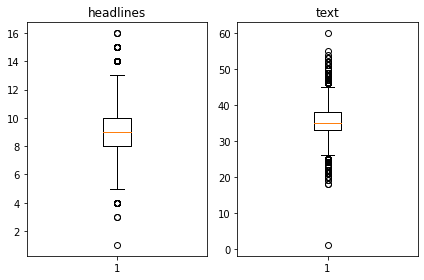

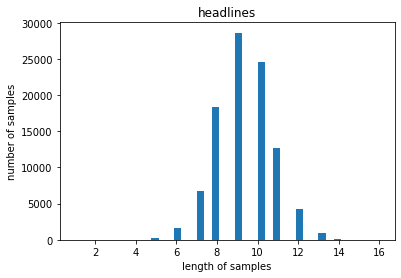

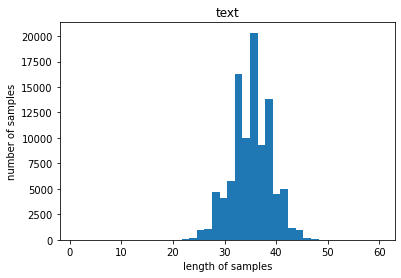

In [11]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 텍스트 길이 1 ~ 60, 평균 35
- 요약 1 ~ 16, 평균 9

이에따라 적절한 최대길이를 설정해보자

In [12]:
text_max_len = 40
headlines_max_len = 11

In [13]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [14]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9449877999186661


개인적인 직관으로 약 90정도의 비율이 남았으면 좋겠다고 생각해서 최대 길이를 적절히 조절했다.

In [15]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 85843


**시작 토큰과 종료 토큰 추가하기**

In [16]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [17]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [18]:
from sklearn.model_selection import train_test_split

encoder_input_train, encoder_input_test,\
decoder_input_train, decoder_input_test,\
decoder_target_train, decoder_target_test = train_test_split(encoder_input, decoder_input, decoder_target, test_size=0.2)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 68674
훈련 레이블의 개수 : 68674
테스트 데이터의 개수 : 17169
테스트 레이블의 개수 : 17169


**단어 집합(vocabulary) 만들기 및 정수 인코딩**

In [19]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [20]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64741
등장 빈도가 6번 이하인 희귀 단어의 수: 44113
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20628
단어 집합에서 희귀 단어의 비율: 68.13765619931728
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.7748851551643403


등장 빈도가 6번 이하인 단어가 희귀단어라면 희귀단어의 비율이 약 70%에 달하지만 등장 비율은 3.8%밖에 되지 않는다.  따라서 이부분을 제거하기 위해서 단어집합의 크기를 줄이려 한다. 희귀단어를 제거 시킬경우 단어 집합의 크기는 약 20000이므로 이에따라, Tokenizer를 다시 정의하고 단어집합을 다시 생성한다.

In [21]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [22]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[3849, 762, 312, 909, 83, 328, 1434, 3371, 3788, 265, 1277, 83, 1, 2118, 64, 312, 909, 1, 320, 1, 312, 2821, 2448, 5516, 5650, 4448, 2448, 4, 1277], [274, 881, 1409, 12272, 19205, 160, 1152, 38, 48, 950, 8342, 5721, 353, 8988, 86, 255, 1047, 5930, 1453, 4, 1710, 64, 3317, 2188, 321, 400, 3066], [756, 25, 3, 5228, 308, 4247, 756, 8989, 287, 3163, 3469, 5069, 608, 912, 9832, 156, 7483, 6960, 3048, 10069, 4537, 3163, 3469, 64, 527, 9832, 64, 17013, 527, 5228, 6, 1675, 13140, 12273]]


<br/>Headline 데이터에 대해서도 위의 과정을 반복한다.

In [23]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [24]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28505
등장 빈도가 5번 이하인 희귀 단어의 수: 18780
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9725
단어 집합에서 희귀 단어의 비율: 65.88317838975618
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.17887103429338


In [25]:
tar_vocab = 9700
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input ',decoder_input_train[:5])
print('decoder ',decoder_target_train[:5])

input  [[1, 539, 424, 3981, 517, 779, 26, 21, 631, 5, 133, 625], [1, 44, 4922, 11, 5142, 119], [1, 1494, 1927, 6636, 77, 3718, 690, 8182, 6637], [1, 38, 1119, 2450, 3, 632, 22, 6638], [1, 81, 2024, 3128, 1304, 7, 214, 23, 42]]
decoder  [[539, 424, 3981, 517, 779, 26, 21, 631, 5, 133, 625, 2], [44, 4922, 11, 5142, 119, 2], [1494, 1927, 6636, 77, 3718, 690, 8182, 6637, 2], [38, 1119, 2450, 3, 632, 22, 6638, 2], [81, 2024, 3128, 1304, 7, 214, 23, 42, 2]]


<br/>길이가 1인경우 제거

In [26]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 2]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 68673
훈련 레이블의 개수 : 68673
테스트 데이터의 개수 : 17169
테스트 레이블의 개수 : 17169


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [27]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## Step 3. 어텐션 매커니즘 사용하기

**모델 설계**

In [28]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [29]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [30]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [31]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

**모델학습**

EarlyStopping을 통해 val_loss가 연속 2번 증가하면 과적합 방지를 위해 학습종료

In [32]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=1024, callbacks=[es], epochs=50)

Epoch 1/50
68/68 [==============================] - 103s 1s/step - loss: 6.9172 - val_loss: 6.0054
Epoch 2/50
68/68 [==============================] - 93s 1s/step - loss: 6.0011 - val_loss: 5.7856
Epoch 3/50
68/68 [==============================] - 94s 1s/step - loss: 5.7707 - val_loss: 5.6080
Epoch 4/50
68/68 [==============================] - 94s 1s/step - loss: 5.5839 - val_loss: 5.4575
Epoch 5/50
68/68 [==============================] - 94s 1s/step - loss: 5.4330 - val_loss: 5.3523
Epoch 6/50
68/68 [==============================] - 94s 1s/step - loss: 5.2572 - val_loss: 5.1875
Epoch 7/50
68/68 [==============================] - 94s 1s/step - loss: 5.0729 - val_loss: 5.0300
Epoch 8/50
68/68 [==============================] - 94s 1s/step - loss: 4.8935 - val_loss: 4.8734
Epoch 9/50
68/68 [==============================] - 94s 1s/step - loss: 4.7245 - val_loss: 4.8049
Epoch 10/50
68/68 [==============================] - 95s 1s/step - loss: 4.5806 - val_loss: 4.6859
Epoch 11/50
68/68 

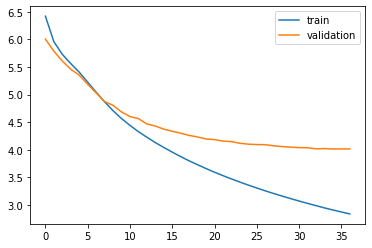

In [33]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

## Step 4. 실제 결과와 요약문 비교하기

**인퍼런스 모델 구현하기**

In [34]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [35]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [36]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [37]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

**모델 테스트하기**

In [38]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [39]:
# 랜덤으로 10개 선택
for i in np.random.choice(len(encoder_input_test), 10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : ias officers association said felt unsafe delhi aap government cm arvind kejriwal said ensure safety security powers resources available command calling bureaucrats part family urged return work end boycott elected government 
실제 요약 : will ensure security kejriwal urges ias officers to resume work 
예측 요약 :  ias officers to be kejriwal as cm kejriwal


원문 : reacting multiple reports american computer software major oracle looking acquire management consulting company accenture oracle clarified rumour completely untrue oracle spokeswoman said company never even considered earlier reports claimed oracle even hired consultants look possible deal 
실제 요약 : rumour of accenture is completely oracle 
예측 요약 :  us man who is the most popular facebook


원문 : soviet union launched world first artificial satellite october amid us soviet cold war launch directly led foundation national aeronautics space administration october weighing kg cm wide satellite transmitted signals days losing speed bu

## Step 5. Summa을 이용해서 추출적 요약해보기

In [40]:
from summa.summarizer import summarize

# 랜덤으로 5개 선택
for i in np.random.choice(1000, 5):
    print("원문 :", seq2text(encoder_input_test[i]))
    
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    
    print("추상적 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("추출적 요약 : ", summarize(seq2text(encoder_input_test[i]), ratio=0.5))
    print("\n")

원문 : first diamond mined depth less km south africa found containing calcium usually formed deep mantle km earth surface researchers said finding proves slabs oceanic crust sink deep within earth recycled lower mantle 
실제 요약 : diamond from km found with km deep 
추상적 요약 :  nasa finds ancient meteorite of earth in the world
추출적 요약 :  


원문 : us president donald trump tweeted big progress made possible trade deal us china deal finalised comprehensive cover points dispute added earlier month countries agreed halt additional trade tariffs goal reaching agreement within days 
실제 요약 : big progress being made trump on trade deal with china 
추상적 요약 :  trump tariffs on china trade trade war trump
추출적 요약 :  


원문 : german chancellor angela merkel said europe longer rely long standing ally us suggesting germany likely assume substantial independent role europe nato previously notably nato first secretary general said purpose keep russians americans germans 
실제 요약 : what is of germany saying it can

추상적 요약의 결과와 추출적 요약을 결과를 비교하며 보기위해서 seq2text를 통해 찾은 원문을 추출적 요약해보았지만 위와같이 결과가 빈값이 나왔다. `preprocess_sentence`를 거친 결과는 전부 빈값이 반환되는데 왜 그런지 이유를 파악하지는 못하였다.<br/>
**그래서 기존의 데이터를 다시 불러와 실제요약과 추출적 요약 결과를 비교해보는 것에서 마무리하려 한다.**

In [41]:
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

# 랜덤으로 5개 선택
for i in np.random.choice(1000, 5):
    print("원문 :", data['text'][i])
    
    print("실제 요약 :", data['headlines'][i])
    
    print("추출적 요약 : ", summarize(data['text'][i], ratio=0.5))
    print("\n")

원문 : The Supreme Court on Wednesday refused bail to Unitech promoters Sanjay Chandra and Ajay Chandra in a case relating to alleged siphoning of homebuyers' money. The apex court said they haven't complied with its October 30, 2017 order to deposit Ã¢ÂÂ¹750 crore with its registry. The brothers have been lodged in Tihar jail for over 18 months.
실제 요약 : SC refuses bail to Unitech promoters for not depositing Ã¢ÂÂ¹750 cr
추출적 요약 :  The Supreme Court on Wednesday refused bail to Unitech promoters Sanjay Chandra and Ajay Chandra in a case relating to alleged siphoning of homebuyers' money.


원문 : Former Pakistan pacer Sarfraz Nawaz criticised the Pakistan Cricket Board for appointing Shoaib Malik as the team's stand-in captain after Sarfraz Ahmed was handed a four-match ban for his racial comments. Nawaz highlighted the fact that the 36-year-old cricketer, in the past, was asked to quit captaincy in PSL amidst suspicions of fixing matches.
실제 요약 : Ex-Pak pacer criticises PCB for naming Ma